<a href="https://colab.research.google.com/github/xujiaxinmeta/Leah_Xu/blob/main/minhashself.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## <center>Similar document searching via MinHash and Locality Sensitive Hashing <center> 
## <center>Name:Xu Jia_Xin
## <center>Class:E1(Tuesday)
## <center>StuNo:2109853qim200011

# Part I: Preliminaries

Write a parse_data function that, given a filename path, reads the article data and returns an array of tuples. Includes the following parts:

∙ One tuple per article (one article per line)

∙ Change all letters to lowercase

∙ Remove all spaces so that all words are concatenated

In [17]:
#The dataset is uploaded to Google Cloud Disk, first load Google Cloud Disk, and then read the file
from google.colab import drive
drive.mount('/content/drive')
import time
import binascii
import random
from bisect import bisect_right
from heapq import heappop, heappush
from __future__ import division
import os
import re
import numpy as np

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
numDocs = 1000
dataFile = "/content/drive/MyDrive/Colab Notebooks/DataMining/data/articles_" + str(numDocs) + ".train"
truthFile = "/content/drive/MyDrive/Colab Notebooks/DataMining/data/articles_" + str(numDocs) + ".truth"

**每个文件内部的形式：**
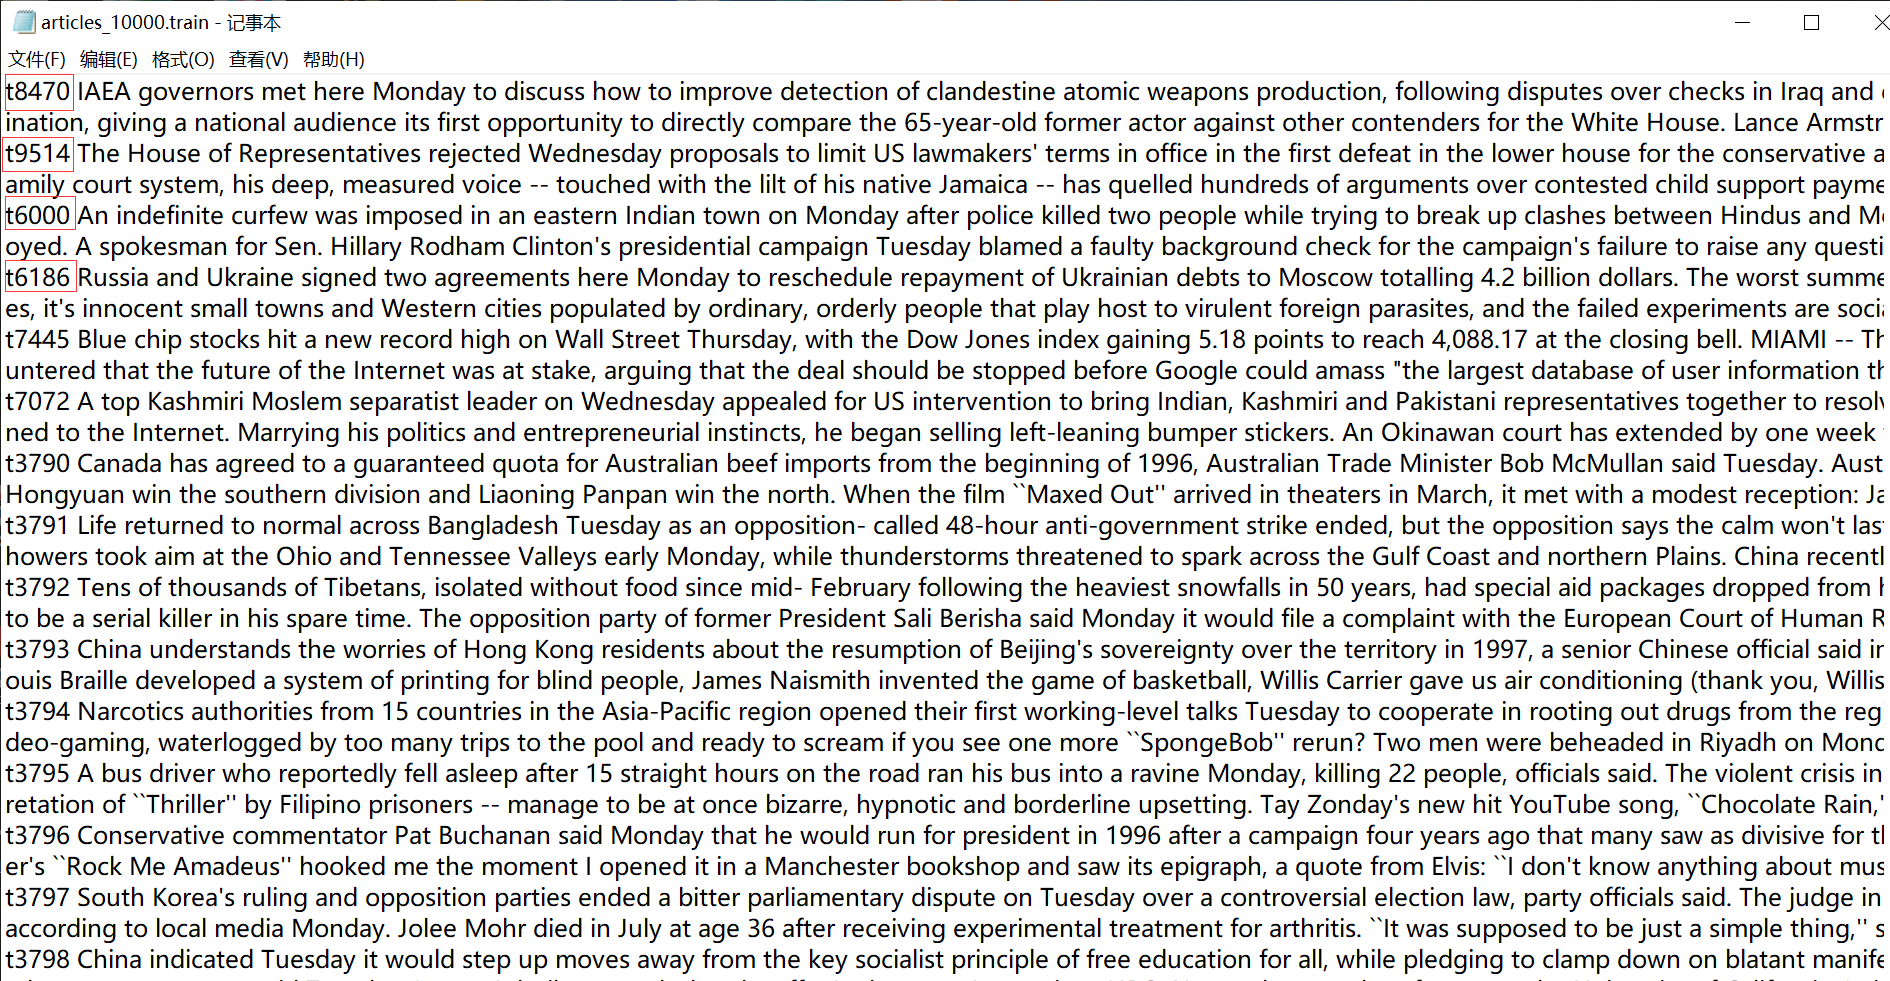

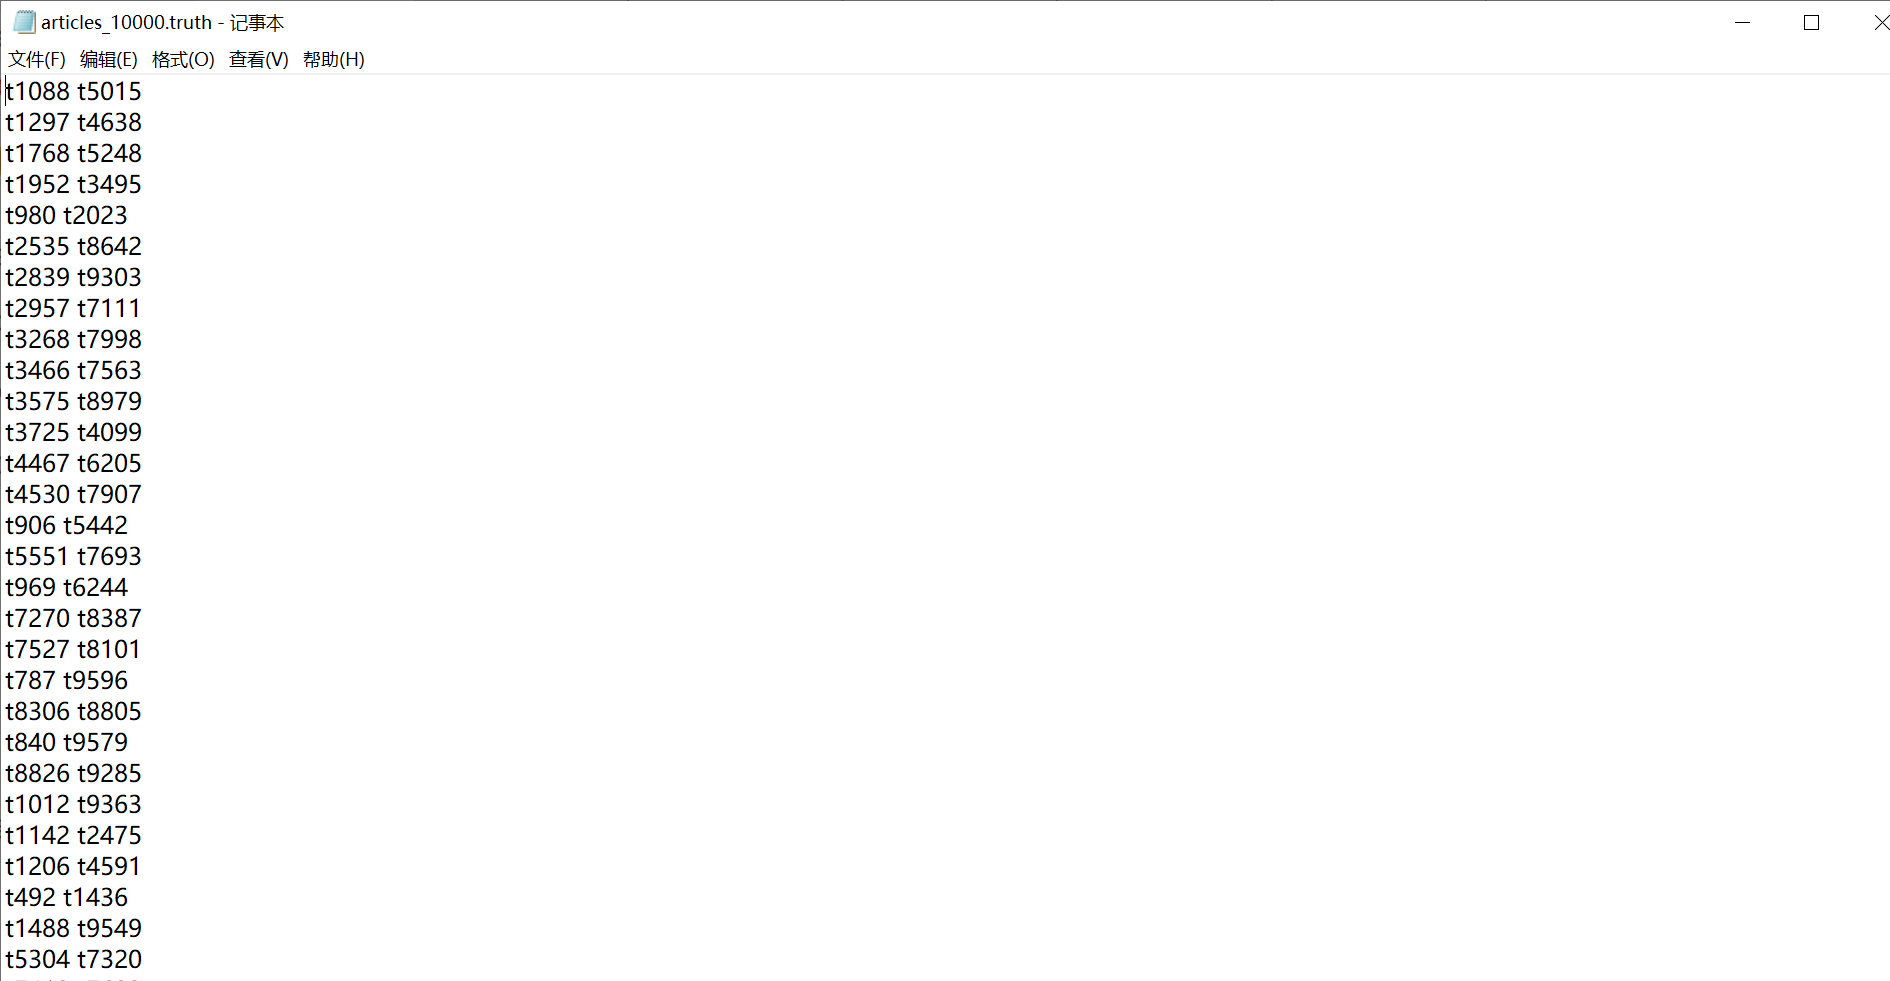

In [3]:
f = open(truthFile, "r")
for line in f:
  if line[-1] == '\n':
      line = line[0:-1]
  docs = line.split(" ")
  #print(docs)
# Map the two documents to each other.
plagiaries={}
plagiaries[docs[0]] = docs[1]
plagiaries[docs[1]] = docs[0]
#docs[0]

Here, the .train file, the dataFile is processed. In this step, the id and string in front of each line should be placed in a dictionary.

And in this part ,we need to caculate the similarity with the Jaccard Similarity:

Function should have skeleton

def jaccard(a, b):
  + compute union size
  + compute intersection size
  + return ratio of union and intersection

In [4]:
t0 = time.time()
#Define an empty tuple to store the id and corresponding string of 
#each line in the .train file
docsAsShingleSets = {}
f = open(dataFile, "r")
docNames = []
totalshinglenum=0
for i in range(0,numDocs):
  words = f.readline().split(" ")
  #like:["t8470","IAEA","governors","met","here","Monday","to","discuss","how","to"]
  docID = words[0]
  docNames.append(docID)
  del words[0]
  shinglesInDoc=set()
  #The words here are articles that contain numDocs, 
  #so each len(words) is the length of each line
  for index in range(0,len(words)-2):
    shingle = (words[index] + " " + words[index + 1] + " " + words[index + 2]).encode()
    #把shingle用Hash the shingle to a 32-bit integer.
    crc = binascii.crc32(shingle) & 0xffffffff
    #Put the converted shingles into shinglesInDoc, 
    #if the repeated shingles are stored only once
    shinglesInDoc.add(crc)
    #Store the complete list of shingles for this document in a dictionary
  docsAsShingleSets[docID]=shinglesInDoc
    #Count the number of shingles across all documents.
  totalshinglenum=totalshinglenum + (len(words) - 2)
#print(docNames)
ggg=[]
for i in range(0,numDocs):
  s1 = docsAsShingleSets[docNames[i]]
  for j in range(i+1,numDocs):
    s2=docsAsShingleSets[docNames[j]]
    # Calculate and store the actual Jaccard similarity.
    #Very time consuming when the dataset is large
    #JSim = len(s1.intersection(s2)) / len(s1.union(s2))
    #ggg.append(JSim)
    #print ("  %5s --> %5s   %.2f" % (docNames[i], docNames[j],JSim))
f.close()  
#print(totalshinglenum)#643492077
print ('\nShingling ' + str(numDocs) + ' total shingles is\n' +str(totalshinglenum))
elapsed = (time.time() - t0)       
print ("caculate jaccard simlarity took %.2fsec" % elapsed )   


Shingling 1000 total shingles is
251239
caculate jaccard simlarity took 0.78sec


When using the 10000 document test in the previous step, the method of pairwise comparison was directly used, and it took 19 minutes and 29 seconds to complete the comparison.


## Experiment 0

Use your function to answer the following question:

What is the effect of sharding length `k** on the Jaccard similarity of plagiarism instances versus instances that are not plagiarized?

To answer this question, make a plot with $k$ in the x-axis and average Jaccard similarity in the y-axis. Plot two lines, one line for plagiarism instances, one line for instances that are not plagiarized. Use the 1000 document dataset for this.

In [24]:
#I will use the code from the previous section 
#with some modifications to complete this experiment
def get_docsAsShingleSets(k):
  docsAsShingleSets = {}
  f = open(dataFile, "r")
  docNames = []
  for i in range(0,numDocs):
    words = f.readline().split(" ")
    docID = words[0]
    docNames.append(docID)
    del words[0]
    shinglesInDoc=set() 
    for index in range(0,len(words)-k+1):
      shingle = (words[index] + " " + words[index + 1] + " " + words[index + 2]).encode()
      crc = binascii.crc32(shingle) & 0xffffffff
      shinglesInDoc.add(crc) 
    docsAsShingleSets[docID]=shinglesInDoc
  plag=[]
  nonplag=[]
  for i in range(0,numDocs):
    s1 = docsAsShingleSets[docNames[i]]
    for j in range(i+1,numDocs):
      s2=docsAsShingleSets[docNames[j]]
      JSim = len(s1.intersection(s2)) / len(s1.union(s2))
      if JSim>0.5:
        plag.append(JSim) 
        #print ("  %5s --> %5s   %.2f" % (docNames[i], docNames[j],JSim)) 
      else:
        nonplag.append(JSim)
  return plag,nonplag

The results of printing each time separately show that the correct plagiarized document can be found regardless of the value of K, so here I only focus on its average similarity affected by K

In [25]:
plag3,nonplag3=get_docsAsShingleSets(3)
print(np.mean(plag3))
print(np.mean(nonplag3))

0.9802495483521353
0.000518578885395672


In [26]:
plag10,nonplag10=get_docsAsShingleSets(10)
print(np.mean(plag10))
print(np.mean(nonplag10))

0.9796846059107617
0.0005009510954254376


In [27]:
plag15,nonplag15=get_docsAsShingleSets(15)
print(np.mean(plag15))
print(np.mean(nonplag15))

0.9792607465415426
0.0004867953970234995


In [28]:
plag20,nonplag20=get_docsAsShingleSets(20)
print(np.mean(plag20))
print(np.mean(nonplag20))

0.9788187027872706
0.0004783943008548787


In [34]:
#Then put them together 
plagiarismset=[]#this is plagiarism documents
nonplagiarismset=[]#this is non-plagiarism documents
for i in range(3,21):
  plag,nonplag=get_docsAsShingleSets(i)
  meanplag=plag
  meanp=np.mean(meanplag)
  nonmeanplag=nonplag
  nonmeanp=np.mean(nonmeanplag)
  plagiarismset.append(meanp)
  nonplagiarismset.append(nonmeanp)

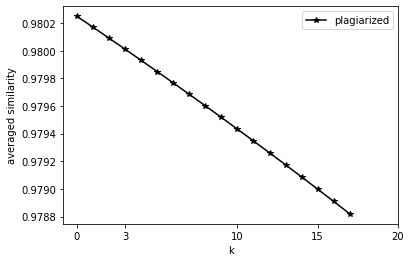

In [39]:
import matplotlib.pyplot as plt
plt.plot(plagiarismset,'k*-')
plt.xlabel('k')
plt.ylabel('averaged similarity')
plt.legend(['plagiarized'])
plt.xticks([0,3, 10, 15, 20])
plt.show()

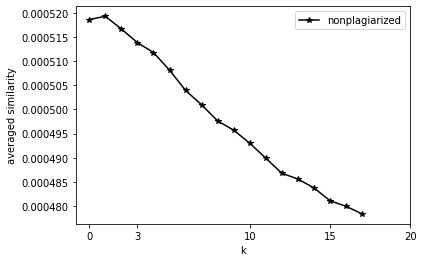

In [41]:
import matplotlib.pyplot as plt
plt.plot(nonplagiarismset,'k*-')
plt.xlabel('k')
plt.ylabel('averaged similarity')
plt.legend(['nonplagiarized'])
plt.xticks([0,3, 10, 15, 20])
plt.show()

Summary about the experiment0:

Through experiments, we know that in the range of 3-20, the larger the k, the smaller the similarity, although the decrease is very small. In the general process of converting documents to shingles, choosing k=3 is a common choice, and from the image, it is also the most accurate, because in written terms of daily work and life, usually by "main" Predicate-object "constitute a grammatical structure.

# Part II：MinHash
(Convert large sets to short signatures,while preserving similarity)

In [42]:
# Define virtual Triangle matrices to hold the similarity values. For storing
# similarities between pairs, we only need roughly half the elements of a full
# matrix. Using a triangle matrix requires less than half the memory of a full
# matrix, and can protect the programmer from inadvertently accessing one of
# the empty/invalid cells of a full matrix.
# Calculate the number of elements needed in our triangle matrix
numElems = int(numDocs * (numDocs - 1) / 2)
# Initialize two empty lists to store the similarity values. 
# 'JSim' will be for the actual Jaccard Similarity values. 
# 'estJSim' will be for the estimated Jaccard Similarities found by comparing
# the MinHash signatures.
JSim = [0 for x in range(numElems)]
estJSim = [0 for x in range(numElems)]
# Define a function to map a 2D matrix coordinate into a 1D index.
def getTriangleIndex(i, j):
  # If i == j that's an error.
  if i == j:
    sys.stderr.write("Can't access triangle matrix with i == j")
    sys.exit(1)
  # If j < i just swap the values.
  if j < i:
    temp = i
    i = j
    j = temp
    # Calculate the index within the triangular array.
  # This fancy indexing scheme is taken from pg. 211 of:
  # http://infolab.stanford.edu/~ullman/mmds/ch6.pdf
  # But I adapted it for a 0-based index.
  # Note: The division by two should not truncate, it
  #       needs to be a float. 
  k = int(i * (numDocs - (i + 1) / 2.0) + j - i) - 1
  return k

In [43]:
maxShingleID = 2**32-1
maxShingleID

4294967295

In [44]:
t1 = time.time()
# Record the maximum shingle ID that we assigned.
maxShingleID = 2**32-1#等4294967295
# We need the next largest prime number above 'maxShingleID'.
nextPrime = 4294967311
def pickRandomCoeffs(k):#k由numHashes决定
  # Create a list of 'k' random values.
  randList = []
  while k > 0:
    # Get a random shingle ID.
    randIndex = random.randint(0, maxShingleID) 
    # Ensure that each random number is unique.
    while randIndex in randList:
      randIndex = random.randint(0, maxShingleID) 
    # Add the random number to the list.
    randList.append(randIndex)
    k = k - 1
  return randList

In [45]:
# For each of the 'numHashes' hash functions, generate a different coefficient 'a' and 'b'.   
numHashes = 20;
coeffA = pickRandomCoeffs(numHashes)
coeffB = pickRandomCoeffs(numHashes)

In [46]:
coeffA

[4019441420,
 3834465223,
 4187032239,
 3345034276,
 1391049969,
 810811439,
 1715071939,
 3322425528,
 985020632,
 3237210358,
 1616697527,
 1006168927,
 3438394938,
 2746409920,
 363625233,
 2210964071,
 1383064486,
 2864827108,
 2441798608,
 3996430184]

In [47]:
coeffB

[3941126826,
 4238115396,
 3840621444,
 2104127131,
 2464221517,
 1632843353,
 4108468251,
 2407030172,
 889881603,
 2826774816,
 3166540498,
 731464527,
 762812272,
 1110436720,
 2552747887,
 3149977173,
 2863305842,
 1496344068,
 3801785236,
 3075842129]

Create signatures pair

In [48]:
signatures = []
for docID in docNames:
  #print(docID)
  shingleIDSet = docsAsShingleSets[docID]
  #Here it is still in crc format, traversing the shingels of each id
  #print(shingleIDSet)
  # The resulting minhash signature for this document.
  signature = []
  for i in range(0, numHashes):
    #numHashes=20
    #For each shingles that actually exists in the document, 
    #use the hash function "i" to calculate its hash code.
    #Initialize "minHashCode" to a value greater than the largest possible value for the hash output
    minHashCode = nextPrime + 1 
    for shingleID in shingleIDSet:
      #Traverse each shingles, then hash to hashcode
      # Evaluate the hash function.
      hashCode = (coeffA[i] * shingleID + coeffB[i]) % nextPrime
      # Track the lowest hash code seen.
      if hashCode < minHashCode:
        minHashCode = hashCode
    # Add the smallest hash code value as component number 'i' of the signature.
    signature.append(minHashCode)
  # Store the MinHash signature for this document.
  signatures.append(signature)
elapsed = (time.time() - t1)
print ("\nGenerating MinHash signatures took %.2fsec" % elapsed ) 


Generating MinHash signatures took 12.89sec


Creates a N x N matrix initialized to 0，Compare All Signatures

In [49]:
t2 = time.time()
for i in range(0, numDocs):
  #Run through the shingles in each article, there are only 20 
  #shingles in each article.
  signature1 = signatures[i]
  for j in range(i + 1, numDocs):
    signature2 = signatures[j]
    count = 0
    #Compare the articles with the same shingles encoding, 
    #and count the number of each two articles compared
    for k in range(0, numHashes):
      count = count + (signature1[k] == signature2[k])
    #The more times, the higher the similarity    
    estJSim[getTriangleIndex(i, j)] = (count / numHashes)
elapsed = (time.time() - t2)        
print ("\nComparing MinHash signatures took %.2fsec" % elapsed)  



Comparing MinHash signatures took 3.30sec


About MinHash function summary:
Calculated by coefficient A, coefficient B and shingles code (crc format), calculate each shingles in shingleIDSet and compare it with minHashCode, and keep the first n (number=numHashes) values, which relies on the generation of hashes. The randomness of the Hitch function has equal randomness for each shingles, if the signature pair composed of the randomness is repeated many times. It shows that the similarity between the two documents is high.

## Experiment 1

What is the effect of the number of hash functions used to compute the Minhash signature on the accuracy of the Minhash estimate of Jaccard similarity. Carry out this experiment on the 1000 document dataset.

This experiment1 will be done together with the next experiment2

# Part III：LSH

## Experiment 2

Use these functions to compute the sensitivity and specificity of LSH as a function of the threshold. Use the 10,000 document dataset to perform this experiment.

Locality-Sensitive Hashing:Focus on pairs of signatures likely to be from similar documents.

In [62]:
# Count the true positives and false positives.
tp = 0
fp = 0
threshold = 0.5  #Set the threshold for determining plagiarism
print ("\nList of Document Pairs with J(d1,d2) more than", threshold)
print ("Values shown are the estimated Jaccard similarity and the actual")
print ("Jaccard similarity.\n")
print ("                   Est. J   Act. J")
plagiaries = {}
# For each of the document pairs...
ESTJ=[]
JAC=[]
for i in range(0, numDocs):  
  for j in range(i + 1, numDocs):
    # Retrieve the estimated similarity value for this pair,use signatures pair
    estJ = estJSim[getTriangleIndex(i, j)]
    # If the similarity is above the threshold...
    if estJ > threshold:
      # Calculate the actual Jaccard similarity for validation.
      s1 = docsAsShingleSets[docNames[i]]
      s2 = docsAsShingleSets[docNames[j]]
      J = (len(s1.intersection(s2)) / len(s1.union(s2)))
      # Print out the match and similarity values with pretty spacing.
      print ("  %5s --> %5s   %.2f     %.2f" % (docNames[i], docNames[j], estJ, J))
      if docsAsShingleSets[docNames[i]] == docNames[j]:   
        tp = tp + 1
      else:
        fp = fp + 1
      ESTJ.append(estJ)
      JAC.append(J)
# Display true positive and false positive counts.
print ("True positives:  " + str(tp) + " / " + str(int(len(plagiaries.keys()) / 2)))
print ("False positives: " + str(fp))
print("\nThis is experiment1's output:")
print("use the MinHash function:",np.mean(ESTJ))
print("use the Jaccard Similarity",np.mean(JAC))


List of Document Pairs with J(d1,d2) more than 0.5
Values shown are the estimated Jaccard similarity and the actual
Jaccard similarity.

                   Est. J   Act. J
   t980 --> t2023   0.90     0.98
  t1088 --> t5015   1.00     0.98
  t1297 --> t4638   1.00     0.98
  t1768 --> t5248   0.90     0.98
  t1952 --> t3495   1.00     0.98
  t2535 --> t8642   1.00     0.98
  t2839 --> t9303   1.00     0.98
  t2957 --> t7111   0.95     0.98
  t3268 --> t7998   0.95     0.98
  t3466 --> t7563   1.00     0.98
True positives:  0 / 0
False positives: 10

This is experiment1's output:
use the MinHash function: 0.97
use the Jaccard Similarity 0.9802495483521353


Summary about experiment1:

Judging from the output results, both methods can accurately find plagiarized documents. Judging from the calculated similarity value, the accuracy rate of directly using Jaccard Similarity is higher than that of MinHash. This is just an experiment where the number of documents is equal to 1000. When the number of documents is larger, the advantage of MinHash will be reflected in the time advantage. In the first part, when the number of documents is 10,000, Jaccard Similarity is used to calculate the similarity and find out the similarity Document, it took nearly 20 minutes, so when the experiment object is a huge data set, the MinHash method is still selected.

## references：
 http://mccormickml.com/2015/06/12/minhash-tutorial-with-python-code/